# Electricity Price Forecasting

## Overview

Data exploration, feature extraction and implementation of a forecasting model for elecricity price given the hisorical price and the load data and wind generation data.

Data used is from the NordPool market, which is freely available from their website NordPoolgroup.com and more information about the dataset is available here: https://sandbox.zenodo.org/record/632147

## Data Exploration

The data will be downloaded, saved locally and then scaled appropriately, before being uploaded to S3

In [1]:
import sys
sys.executable

'/home/ec2-user/anaconda3/envs/python3/bin/python'

In [1]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from epftoolbox.data import read_data
from epftoolbox.data import DataScaler
import matplotlib.pyplot as plt
import io
import os
import time
import json


# Session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/EPF_linear_learner'

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

In [60]:
path = 'NordPool_data/'
dataset = 'NP'
# Want our test dataset to be the last 2 years of the total dataset, which is 6 years
years_test = 2 
df_train, df_test = read_data(path=path, dataset=dataset, years_test=years_test)
df_train.head()

,Price,Exogenous 1,Exogenous 2
Date,,,
2013-01-01 00:00:00,31.05,42497.0,2798.0
2013-01-01 01:00:00,30.47,41463.0,2417.0
2013-01-01 02:00:00,28.92,40812.0,2036.0
2013-01-01 03:00:00,27.88,40246.0,1706.0
2013-01-01 04:00:00,26.96,40088.0,1427.0


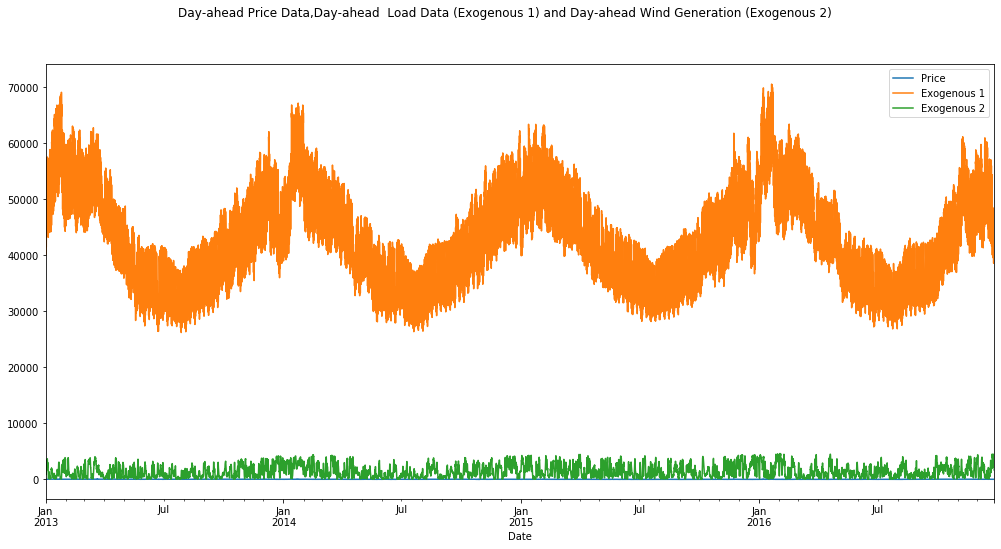

In [67]:
df_train.plot(figsize=(17, 8))
plt.suptitle('Day-ahead Price Data,Day-ahead  Load Data (Exogenous 1) and Day-ahead Wind Generation (Exogenous 2)')
plt.savefig('Data_Unscaled.pdf')

For this model, we will use the day-ahead load forecast (exogenous 1) and the day-ahead wind generation forecast (exgobenous 2) as our input data, and the day ahead price of eletricity as our label, in order to make a model that can predict the day-ahead price, given the wind and the load forcasts.

As seen from the above plot, the values for the day-ahead load forecast and the day-ahead wind generation forecast are so much greater than the day-ahead price, that the price data is barely visible on the plot.

This indicates the data needs to be scaled prior to training or testing.

You can also see weekly and seasonal trends in the data above (e.g. greater day ahead load forecast in the winter momths than summer etc) so this indicates that extracting some of these features could improve our model.

### Data Visualisation

Text(0.5, 0.98, 'Day-ahead Price Data, Jan 2013 - Dec 2016')

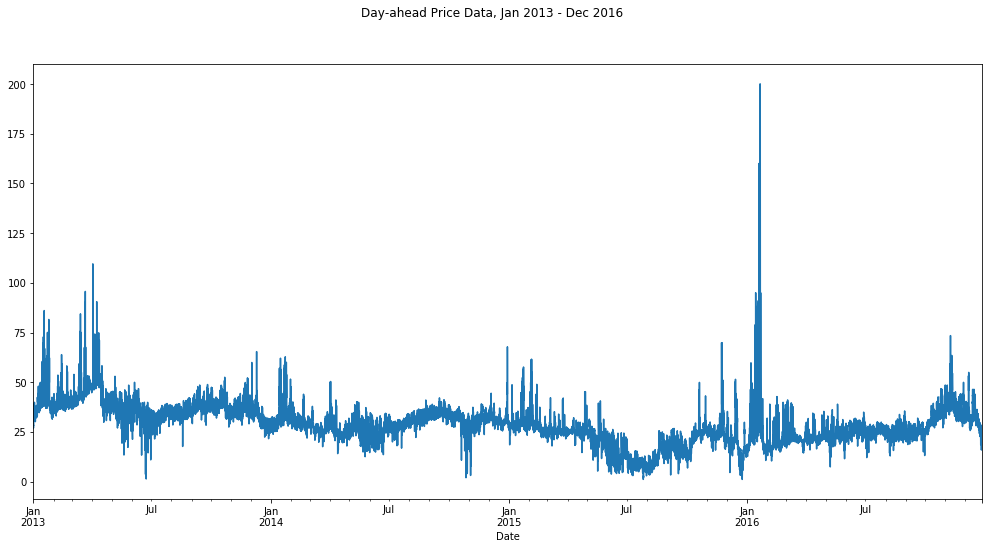

In [14]:
df_train.Price.plot(figsize=(17, 8))
plt.suptitle('Day-ahead Price Data, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Load Forecast, Jan 2013 - Dec 2016')

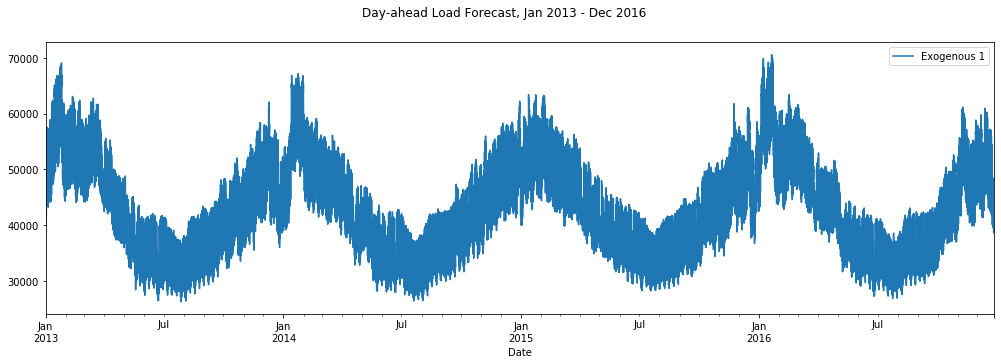

In [21]:
df_train.plot(y='Exogenous 1', figsize=(17, 5))
plt.suptitle('Day-ahead Load Forecast, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

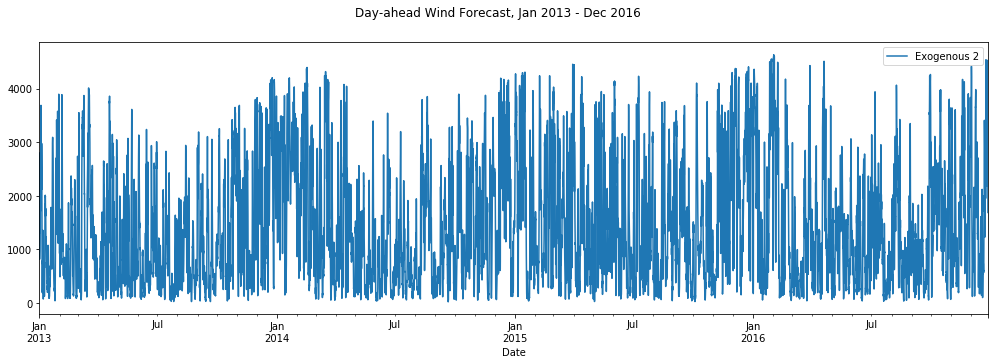

In [22]:
df_train.plot(y='Exogenous 2', figsize=(17, 5))
plt.suptitle('Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

### Feature Engineering
The features we want to extract from our time series data are as follows:
1. The day of the week, as an int (0 = Monday, 6 = Sunday)
2. The week ordinal of the year
3. The month, as an int
4. The hour of the datetime
5. Lag features for price, for each day of the week.

In [10]:
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)
df_train['Day']=df_train.index.dayofweek
df_test['Day']=df_test.index.dayofweek
df_train['Week']=df_train.index.week
df_test['Week']=df_test.index.week
df_train['Month']=df_train.index.month
df_test['Month']=df_test.index.month
df_train['Hour']=df_train.index.hour
df_test['Hour']=df_test.index.hour

df_train.head()

,Price,Exogenous 1,Exogenous 2,weekday,Week,Month,Hour,Day
Date,,,,,,,,
2013-01-01 00:00:00,31.05,42497.0,2798.0,1,1,1,0,1
2013-01-01 01:00:00,30.47,41463.0,2417.0,1,1,1,1,1
2013-01-01 02:00:00,28.92,40812.0,2036.0,1,1,1,2,1
2013-01-01 03:00:00,27.88,40246.0,1706.0,1,1,1,3,1
2013-01-01 04:00:00,26.96,40088.0,1427.0,1,1,1,4,1


In [11]:
# Lag Features
df_train['lag1'] = df_train['Price'].shift(1)
df_test['lag1'] = df_test['Price'].shift(1)
df_train['lag2'] = df_train['Price'].shift(2)
df_test['lag2'] = df_test['Price'].shift(2)
df_train['lag3'] = df_train['Price'].shift(3)
df_test['lag3'] = df_test['Price'].shift(3)
df_train['lag4'] = df_train['Price'].shift(4)
df_test['lag4'] = df_test['Price'].shift(4)
df_train['lag5'] = df_train['Price'].shift(5)
df_test['lag5'] = df_test['Price'].shift(5)
df_train['lag6'] = df_train['Price'].shift(6)
df_test['lag6'] = df_test['Price'].shift(6)
df_train['lag7'] = df_train['Price'].shift(7)
df_test['lag7'] = df_test['Price'].shift(7)

df_test.head()

,Price,Exogenous 1,Exogenous 2,weekday,Week,Month,Hour,Day,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,,,,,,,
2016-12-27 00:00:00,24.08,42653.0,2124.0,1,52,12,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-27 01:00:00,22.52,41868.0,1905.0,1,52,12,1,1,24.08,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-27 02:00:00,20.13,41534.0,2053.0,1,52,12,2,1,22.52,24.08,NaN,NaN,NaN,NaN,NaN
2016-12-27 03:00:00,19.86,41642.0,2274.0,1,52,12,3,1,20.13,22.52,24.08,NaN,NaN,NaN,NaN
2016-12-27 04:00:00,20.09,42418.0,2549.0,1,52,12,4,1,19.86,20.13,22.52,24.08,NaN,NaN,NaN


In [20]:
# Remove NaN from lag features
df_train = df_train.iloc[7:,]
df_test = df_test.iloc[7:,]

# Create validation set as the last year in the training data
df_val = df_train.loc['2016-01-01 00:00:00': '2016-12-26 23:00:00']
df_train = df_train.loc['2013-01-01 00:00:00': '2015-12-31 23:00:00']

### Data Scaling
Create a scaler for the input data - Scaling the data to follow a normal distribution

In [31]:
train_y = df_train['Price']
val_y = df_val['Price']
test_y = df_test['Price']

train_X = df_train.drop('Price', axis=1).to_numpy()
validation_X = df_val.drop('Price', axis=1).to_numpy()
test_X = df_test.drop('Price', axis=1).to_numpy()
df_train.head()

,Price,Exogenous 1,Exogenous 2,weekday,Week,Month,Hour,Day,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,,,,,,,
2013-01-03 14:00:00,36.42,55768.0,3686.0,3,1,1,14,3,36.40,36.51,36.60,36.71,36.52,36.38,35.82
2013-01-03 15:00:00,36.58,56413.0,3679.0,3,1,1,15,3,36.42,36.40,36.51,36.60,36.71,36.52,36.38
2013-01-03 16:00:00,36.94,57285.0,3644.0,3,1,1,16,3,36.58,36.42,36.40,36.51,36.60,36.71,36.52
2013-01-03 17:00:00,36.94,57558.0,3553.0,3,1,1,17,3,36.94,36.58,36.42,36.40,36.51,36.60,36.71
2013-01-03 18:00:00,36.81,56793.0,3440.0,3,1,1,18,3,36.94,36.94,36.58,36.42,36.40,36.51,36.60


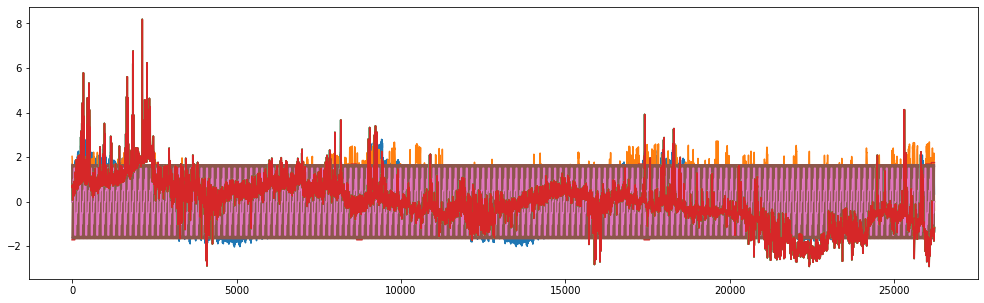

In [23]:
# Using the DataScaler class from the EPF toolbox.
# Passing DataScaler the 'Std' parameter will standardize the data to 
# follow a normal distribution.
scaler_X = DataScaler('Std')
Xtrain_scaled = scaler_X.fit_transform(train_X)
Xtest_scaled = scaler_X.transform(test_X)
Xval_scaled = scaler_X.transform(validation_X)

#Xtrain_inverse = scaler_X.inverse_transform(Xtrain_scaled)
#Xtest_inverse = scaler_X.inverse_transform(Xtest_scaled)

plt.figure(figsize=(17,5))
plt.plot(Xtrain_scaled)


Create a scaler for the output

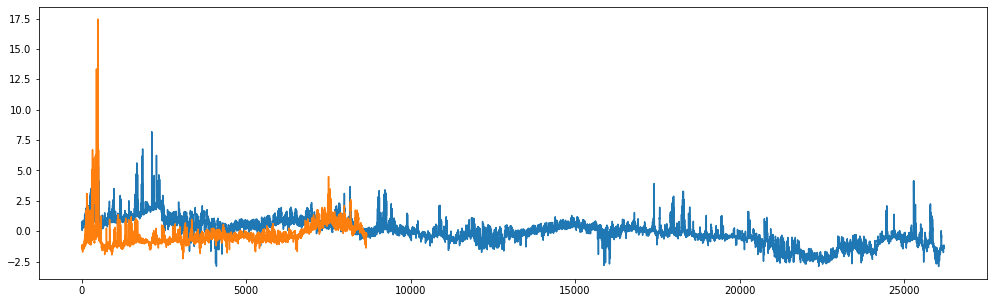

In [27]:
train_y_arr = train_y.to_numpy()
YtrainR = train_y_arr.reshape(-1,1)
val_y_arr = val_y.to_numpy()
YvalR = val_y_arr.reshape(-1,1)
#print(YtrainR[0:3])

# Use the same type of normalisation as the test data
scaler_Y = DataScaler('Std')
Ytrain_scaled = scaler_Y.fit_transform(YtrainR)
Yval_scaled = scaler_Y.transform(YvalR)
plt.figure(figsize=(17,5))
plt.plot(Ytrain_scaled)
plt.plot(Yval_scaled)

# Note: 
# train_y = Ytrain_scaled
# validate_y = Yval_scaled
# train_X = Xtrain_scaled
# validate_X = Xval_scaled
# test_X = Xtest_scaled

## Training

Now that all of our data has been scaled appropriately, we can use it to train or model.

### Upload to S3
Reshape the data and convert into pd.Series object

In [37]:
train_y = Ytrain_scaled.reshape(-1)
validate_y = Yval_scaled.reshape(-1)

print(train_y.shape)
# Turn lables back into Series object
train_y = pd.Series(train_y)
validate_y = pd.Series(validate_y)
validate_y.head()

(26218,)


0   -1.346392
1   -1.382195
2   -1.412884
3   -1.430274
4   -1.440503
dtype: float64

SageMaker algorithms require the data to be in recordIO-wrapped protobuf format

In [34]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(Xtrain_scaled).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

0

In [ ]:
key = 'linear_train_feat.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

In [38]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(Xval_scaled).astype('float32'), np.array(validate_y).astype('float32'))
buf.seek(0)

0

In [39]:
key = 'linear_val_feat.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(buf)
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-eu-west-1-871247501960/sagemaker/EPF_linear_learner/validation/linear_val_feat.data


### Create an estimator

In [36]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [41]:
estimator = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sagemaker_session)

estimator.set_hyperparameters(feature_dim=14,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=30,
                           early_stopping_patience = 5,
                           learning_rate = 0.01,
                           normalize_label = 'false',
                           loss='quantile_loss')



train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Hyperparameter Tuning

In [44]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

linear_hyperparameter_tuner = HyperparameterTuner(estimator = estimator,
                                                 objective_metric_name = 'validation:objective_loss',
                                                 objective_type = 'Minimize',
                                                 max_jobs = 6,
                                                 max_parallel_jobs = 3,
                                                 hyperparameter_ranges = {
                                                     'learning_rate':ContinuousParameter(0.01,0.3),
                                                     'mini_batch_size':IntegerParameter(100,500),
                                        
                                                 })

In [45]:
linear_hyperparameter_tuner.fit({'train': s3_train_data, 'validation': s3_validation_data})

....................................................................................................................!


In [46]:
linear_hyperparameter_tuner.wait()

!


## Deployment

Deploy the trained model to an endpoint, in order to pass in test data for prediction

In [47]:
estimator_tuned = sagemaker.estimator.Estimator.attach(linear_hyperparameter_tuner.best_training_job())


2020-11-23 07:22:09 Starting - Preparing the instances for training
2020-11-23 07:22:09 Downloading - Downloading input data
2020-11-23 07:22:09 Training - Training image download completed. Training in progress.
2020-11-23 07:22:09 Uploading - Uploading generated training model
2020-11-23 07:22:09 Completed - Training job completed


In [47]:
predictor = estimator_tuned.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

-------------!

In [49]:
predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

In [51]:
result = predictor.predict(Xtest_scaled)

prediction = np.array([r['score'] for r in result['predictions']])
#print(one_step.shape)

# Perform inverse scaling transform on predictions
prediction_scaled = scaler_Y.inverse_transform(prediction.reshape(1,-1))


The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [53]:
pred = prediction_scaled.reshape(-1)
test_y = test_y.values

print(type(test_y))
print(type(pred))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [62]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

MAPE = np.mean(np.abs(test_y - pred) / test_y)
print('MAPE of Predictions = ', MAPE)

MAE = mean_absolute_error(test_y, pred)
print('MAE of Predictions = ', MAE)

RMSE = sqrt(mean_squared_error(test_y, pred))
print('RMSE of Predictions = ', RMSE)

MAPE of Predictions =  0.029083059487631808
MAE of Predictions =  1.0120022217180058
RMSE of Predictions =  2.333939962385207


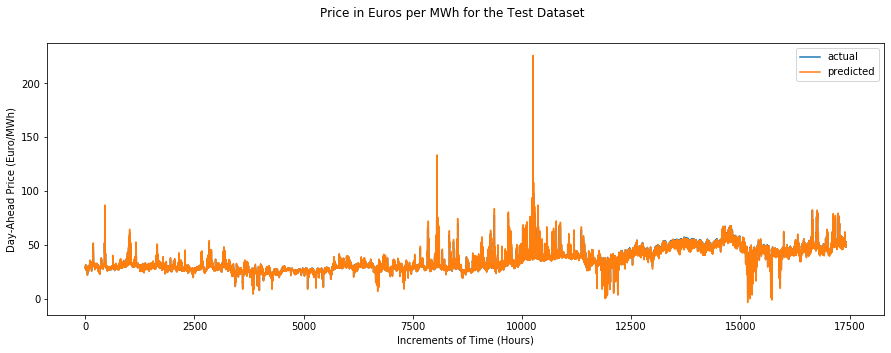

<Figure size 432x288 with 0 Axes>

In [65]:
plt.figure(figsize=(15,5))
plt.plot(np.array(test_y), label='actual')
plt.plot(pred, label='predicted')
plt.suptitle('Price in Euros per MWh for the Test Dataset')
plt.xlabel('Increments of Time (Hours)')
plt.ylabel('Day-Ahead Price (Euro/MWh)')
plt.legend()
plt.show()
plt.savefig('Predictions.pdf')

## Delete Endpoint

In [66]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
